# PyCPT Seasonal

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).


#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.


### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work = 'Final_Test3'

########Some folder and file options:
# Where do you want to make the work folder-- this should already exist!!! 
workdir = "C:/Users/sysadmin/Projects/pctpt2/PyCPT-Dev/"
# PATH to CPT directory (folder containing CPT.x (Mac / Unix) or CPT_Batch.exe (Windows))
cptdir='C:/CPT4/'
shp_file = 'None'# '/Users/kylehall/Projects/PyCPT/PyCPT-Dev/local/sascof_boundary_final.shp' #path from pycpt_functions_seasonal.py to your shape file
use_default = 'True' #Make False to turn off default country boundaries

########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']

#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=['Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='ENACTS-BD'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA' 


#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5
eofmodes = 3 #number of EOF modes to compute

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=[ 'May', 'Sep']
tgti=['1.5', '1.5']  #S: start for the DL
tgtf=['4.5', '3.5']   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Jun-Sep', 'Oct-Dec']

tini = 1982
tend = 2009

########Forecast date  
monf=['May', 'Sep'] 	# Initialization month 
fyr=2019 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude


#If you have local observations data, please provide some metadata here!
local_obs_files = ['none', 'none'] #['../local/Merged_data_OND_1982_2019.tsv', '../local/MERGED_DATA_JJAS_1982_2019.tsv']#['../MERGED_DATA_S_ASIA_1982_2019_JJAS.nc','../Merged_data_yrmean_OND_1982_2019.nc'] #either 'None' if you don't have local data, or the path of your local obs data file
local_obs_LongitudeKey = 'LONGITUDE' #ncdf key for accessing latitude - must be the same for all files
local_obs_LatitudeKey = 'LATITUDE'   #ncdf key for accessing longitude
local_obs_timeKey = 'time'           #ncdf key for accessing time
local_obs_datakey = 'rf'             #ncdf key for accessing data itself


### End of namelist section 

#### Load Libraries

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform


pycpt = PyCPT_Args(workdir, work, cptdir, models, met, obs, station, MOS, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, eofmodes, PREDICTAND, PREDICTOR, mons, tgti, tgtf, tgts, tini, tend, monf, fyr, force_download, nla1, sla1, wlo1, elo1, nla2, sla2, wlo2, elo2, local_obs_files, local_obs_LongitudeKey, local_obs_LatitudeKey, local_obs_timeKey, local_obs_datakey, shp_file, use_default)
setup_directories(work, workdir, force_download, cptdir)


A subdirectory or file scripts already exists.
A subdirectory or file images already exists.
A subdirectory or file input already exists.
A subdirectory or file output already exists.


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

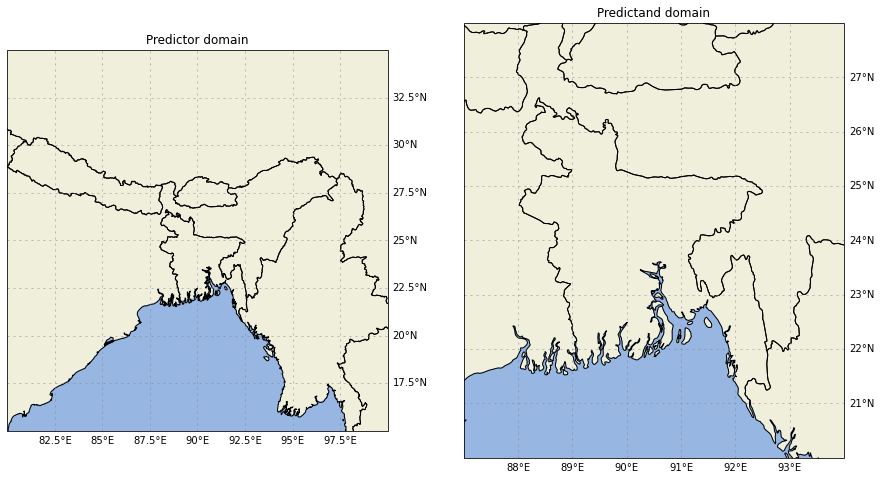

In [3]:
#Plot domains
pycpt.pltdomain()

# Download data if necessary, and run CPT

In [4]:

#If downloadling data from several models, this section might take a while to be done
for model in range(len(models)):
    print('\n\n\n--------Starting process for '+models[model]+'--------')
    for tgt in range(len(mons)):
    
        ########Set Up Useful Variables Automatically - tini & tend may change based on tgt
        pycpt.setupParams(tgt)
            
        #download input files for CPT
        pycpt.prepFiles(tgt, model)
        
        #write CPT input script automatically
        pycpt.CPTscript(tgt, model)
        
        #run CPT
        pycpt.run(tgt, model)
        




--------Starting process for COLA-RSMAS-CCSM4--------
Predictand is Rainfall Total (mm)
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Hindcasts precip file doesn't exist --SOLVING: downloading file

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/4/mul/T/%28Jan%201982%29/%28Dec%202010%29/RANGE/T/%28Jun-Sep%29/seasonalAverage/Y/%2820%29/%2828%29/RANGEEDGES/X/%2887%29/%2894%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
curl -k https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rain

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   180k      0  0:00:01 --:--:--  0:00:01  722k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20May%202019%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0  8192    0     0   8192      0  0:12:03  0:00:01  0:12:02  4768
  1 5791k    1 69632    0     0  34816      0  0:02:50  0:00:02  0:02:48 25914
  3 5791k    3  216k    0     0  73728      0  0:01:20  0:00:03  0:01:17 60251
  9 5791k    9  560k    0     0   140k      0  0:00:41  0:00:04  0:00:37  120k
 22 5791k   22 1276k    0     0   255k      0  0:00:22  0:00:05  0:00:17  260k
 39 5791k   39 2308k    0     0   384k      0  0:00:15  0:00:06  0:00:09  468k
 64 5791k   64 3764k    0     0   537k      0  0:00:10  0:00:07  0:00:03  748k
 95 5791k   95 5516k    0     0   689k      0  0:00:08  0:00:08 --:--:-- 1063k
100 5791k  100 5791k    0     0   723k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0   6724      0  0:00:01 --:--:--  0:00:01 30703


        1 file(s) copied.
Executing CPT for COLA-RSMAS-CCSM4 and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_COLA-RSMAS-CCSM4_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/3/mul/T/%28Jan%2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   180k      0  0:00:01 --:--:--  0:00:01 1157k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20Sep%202019%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 24576    0     0  24576      0  0:04:01  0:00:01  0:04:00 14173
  1 5791k    1  108k    0     0  55296      0  0:01:47  0:00:02  0:01:45 40450
  5 5791k    5  316k    0     0   105k      0  0:00:54  0:00:03  0:00:51 87008
 12 5791k   12  744k    0     0   186k      0  0:00:31  0:00:04  0:00:27  157k
 24 5791k   24 1444k    0     0   288k      0  0:00:20  0:00:05  0:00:15  307k
 41 5791k   41 2412k    0     0   402k      0  0:00:14  0:00:06  0:00:08  479k
 68 5791k   68 3940k    0     0   562k      0  0:00:10  0:00:07  0:00:03  766k
100 5791k  100 5791k    0     0   723k      0  0:00:08  0:00:08 --:--:-- 1130k


Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0   6724      0  0:00:01 --:--:--  0:00:01 61127


        1 file(s) copied.
Executing CPT for COLA-RSMAS-CCSM4 and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_COLA-RSMAS-CCSM4_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------






--------Starting process for GFDL-CM2p5-FLOR-A06--------
Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization May...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-A06/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURC

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 17  180k   17 32768    0     0  32768      0  0:00:05 --:--:--  0:00:05 38824
100  180k  100  180k    0     0   180k      0  0:00:01 --:--:--  0:00:01  202k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-A06/.MONTHLY/.prec/S/%280000%201%20May%202019%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 28672    0     0  14336      0  0:06:53  0:00:02  0:06:51 12743
  2 5791k    2  116k    0     0  39594      0  0:02:29  0:00:03  0:02:26 36381
  5 5791k    5  324k    0     0  82944      0  0:01:11  0:00:04  0:01:07 77499
 12 5791k   12  724k    0     0   144k      0  0:00:39  0:00:05  0:00:34  148k
 25 5791k   25 1500k    0     0   250k      0  0:00:23  0:00:06  0:00:17  308k
 46 5791k   46 2688k    0     0   384k      0  0:00:15  0:00:07  0:00:08  549k
 73 5791k   73 4252k    0     0   531k      0  0:00:10  0:00:08  0:00:02  853k
100 5791k  100 5791k    0     0   723k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0   6724      0  0:00:01 --:--:--  0:00:01 28735


        1 file(s) copied.
Executing CPT for GFDL-CM2p5-FLOR-A06 and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-A06_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-A06/.MONTHLY/.prec/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/3/mu

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   180k      0  0:00:01 --:--:--  0:00:01  722k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-A06/.MONTHLY/.prec/S/%280000%201%20Sep%202019%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0  8192    0     0   8192      0  0:12:03  0:00:01  0:12:02  4853
  1 5791k    1 77824    0     0  38912      0  0:02:32  0:00:02  0:02:30 28952
  3 5791k    3  228k    0     0  77824      0  0:01:16  0:00:03  0:01:13 67302
  9 5791k    9  536k    0     0   134k      0  0:00:43  0:00:04  0:00:39  119k
 16 5791k   16  984k    0     0   164k      0  0:00:35  0:00:06  0:00:29  180k
 16 5791k   16  984k    0     0   164k      0  0:00:35  0:00:06  0:00:29  197k
 21 5791k   21 1256k    0     0   179k      0  0:00:32  0:00:07  0:00:25  236k
 22 5791k   22 1296k    0     0   162k      0  0:00:35  0:00:08  0:00:27  204k
 24 5791k   24 1416k    0     0   157k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0   6724      0  0:00:01 --:--:--  0:00:01 61688


        1 file(s) copied.
Executing CPT for GFDL-CM2p5-FLOR-A06 and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-A06_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------





## Deterministic Skill Analysis

Predictand is Rainfall Total (mm)

Pearson
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


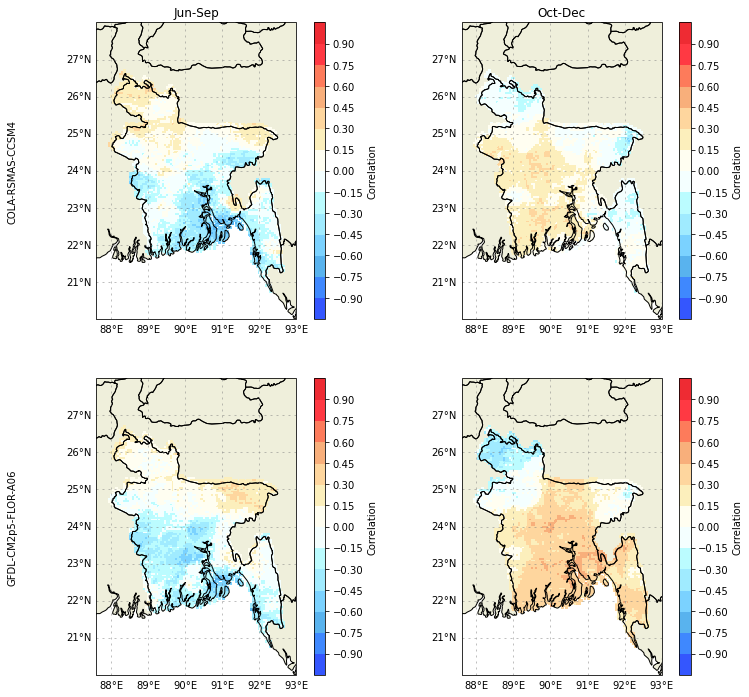


Spearman
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


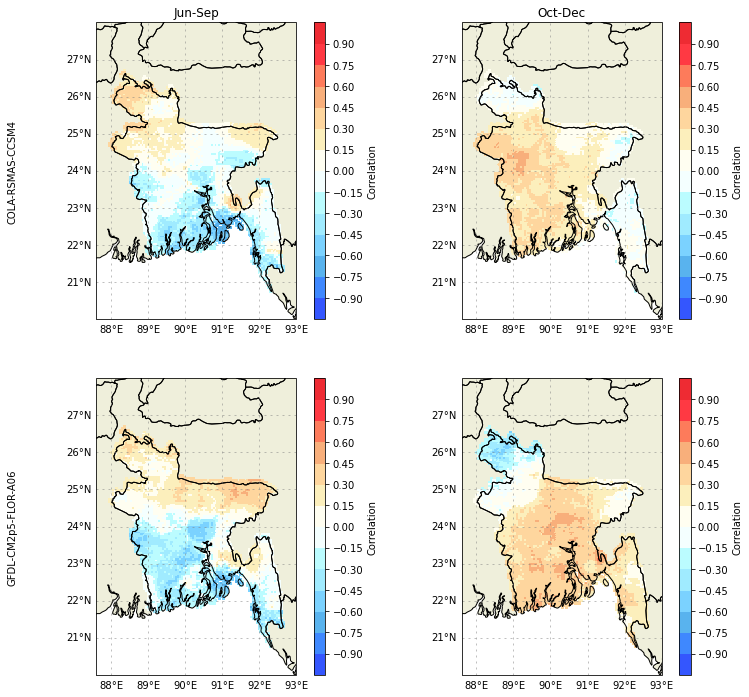


2AFC
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


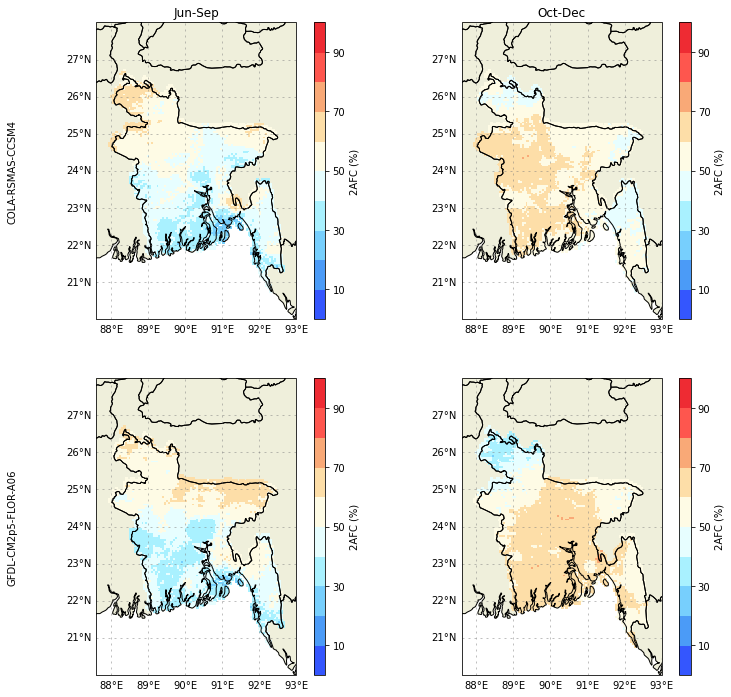


RocAbove
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


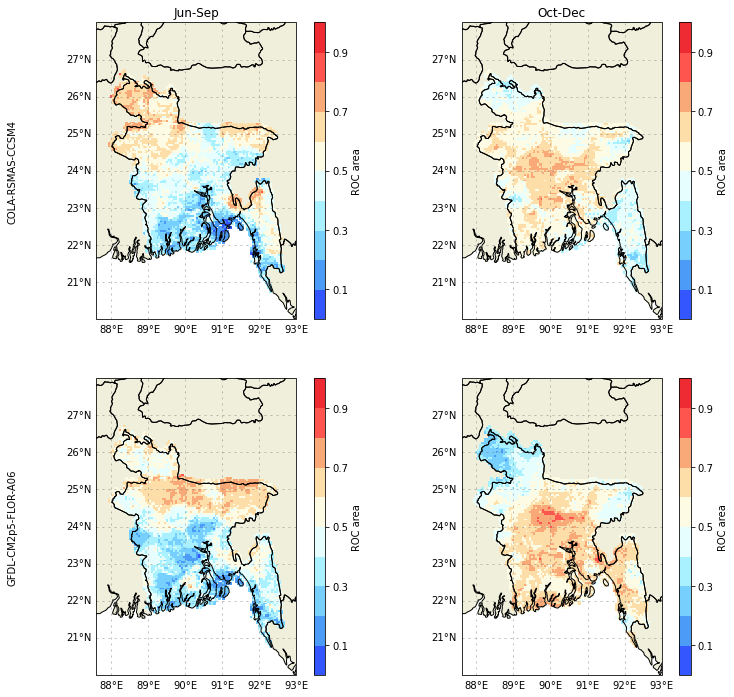


RocBelow
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


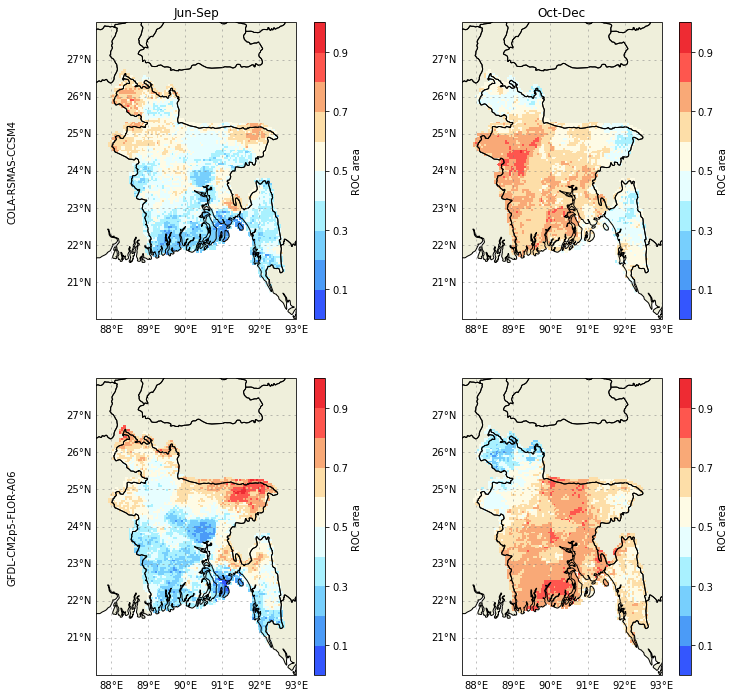


RMSE
failed to add your shape file
failed to add your shape file
failed to add your shape file
failed to add your shape file


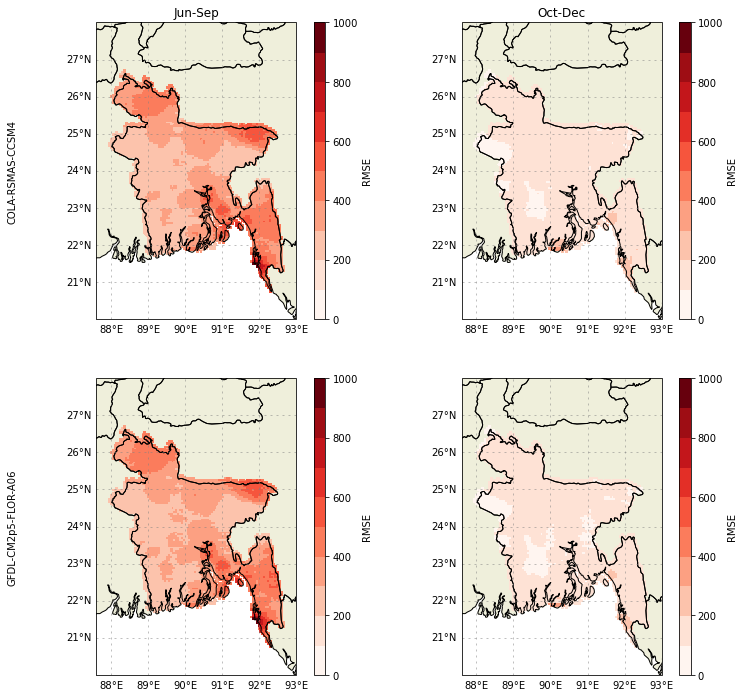

In [3]:
# Skill scores loop
pycpt.setupParams(0)
for ime in range(len(met)):
    pycpt.pltmap(ime)   


##### EOF Analysis (only available if MOS=PCR or CCA)




-------------EOF 1-------------



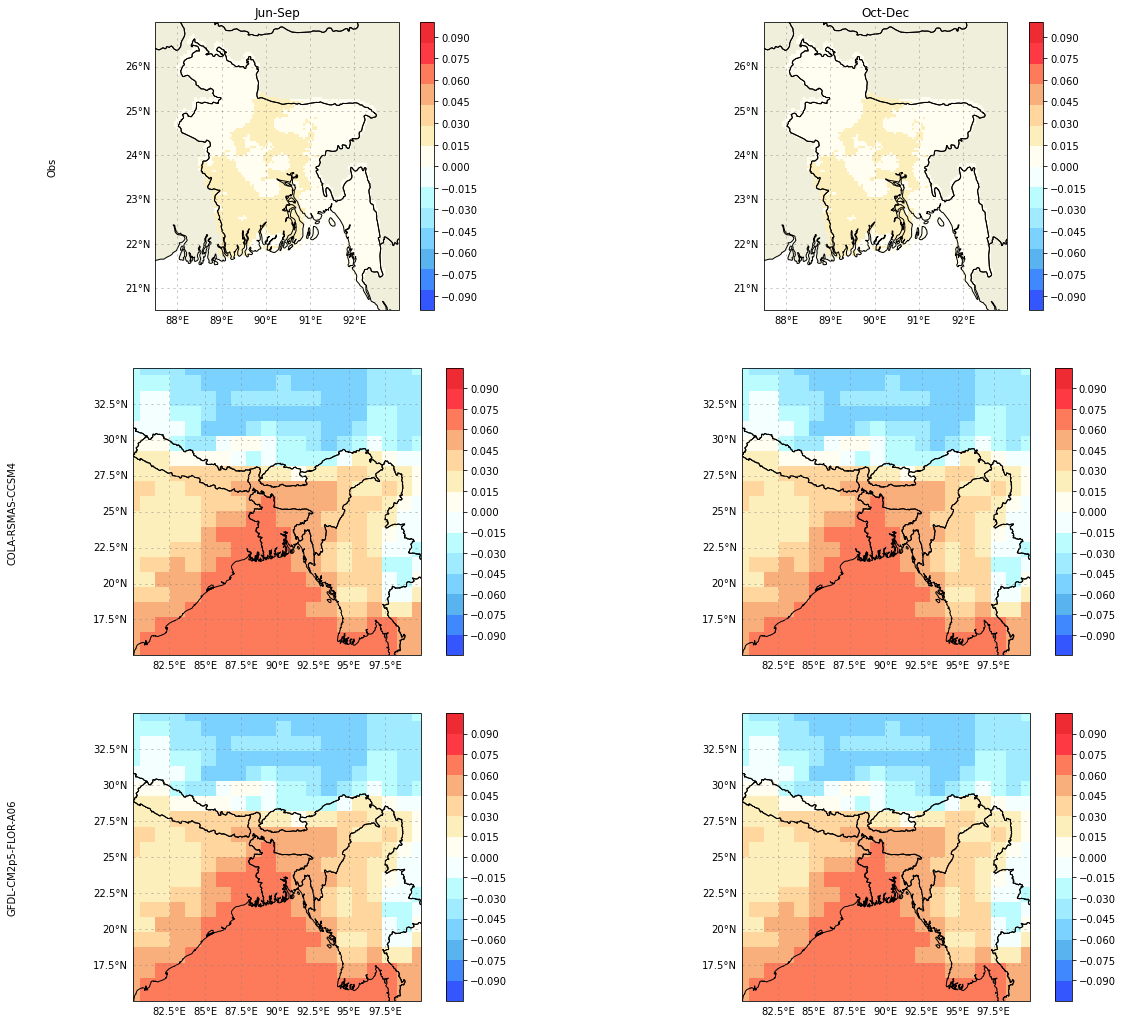




-------------EOF 2-------------



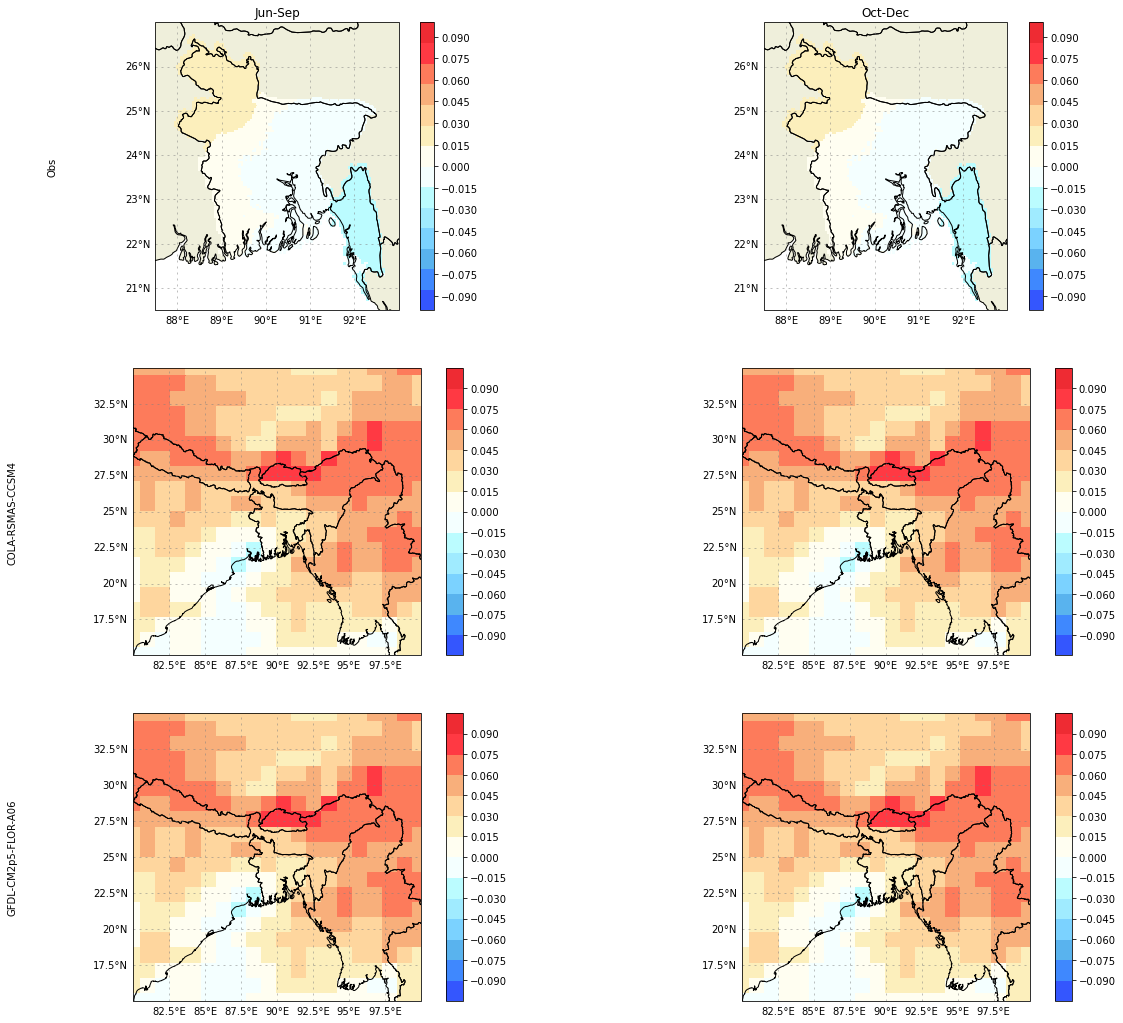




-------------EOF 3-------------



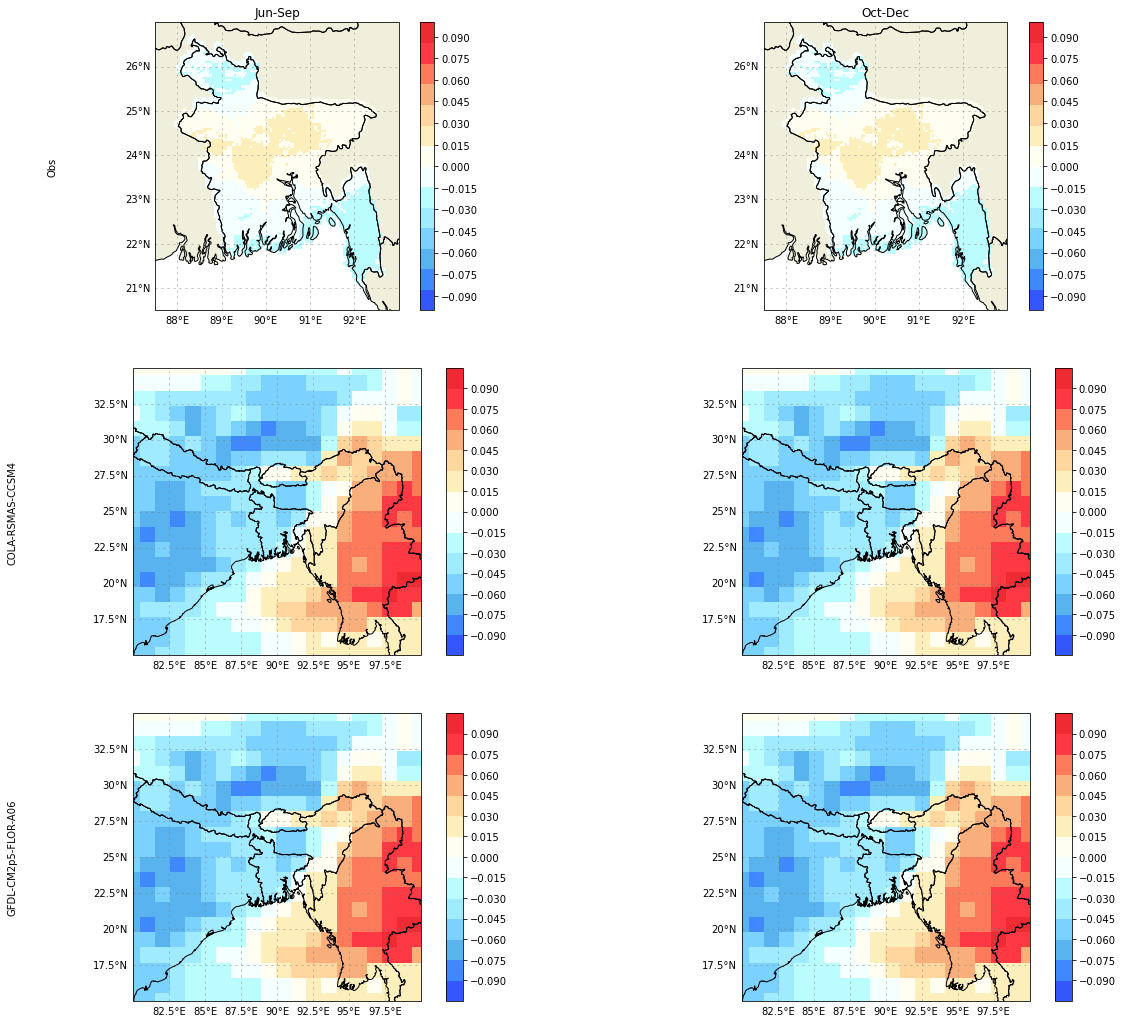

In [6]:
# Skill scores loop
if MOS in ['PCR', 'CCA']:
    for imod in range(eofmodes):
        pycpt.plteofs(imod)  

## Multi-model ensemble: NextGen

In [7]:
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']
pycpt.setNextGenModels(models)


for tgt in range(len(tgts)):

    #prepare files for nextgen input using simple mean
    pycpt.NGensemble(tgt)

    #write CPT input script for NextGen
    pycpt.CPTscript(tgt)

    #run CPT for nextgen
    pycpt.run(tgt)

Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization May...
Cross-validated prediction files successfully produced
        1 file(s) copied.
Executing CPT for NextGen and initialization May...
Unfortunately Windows Batch version doesnt do quite everything correctly- we get a memory access error here, but the rest of the notebook will still work fine! Everything for NextGen Skill analysis / forecasting works perfect

----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...
Cross-validated prediction files successfully produced
        1 file(s) copied.
Execut


Pearson
failed to add your shape file
failed to add your shape file


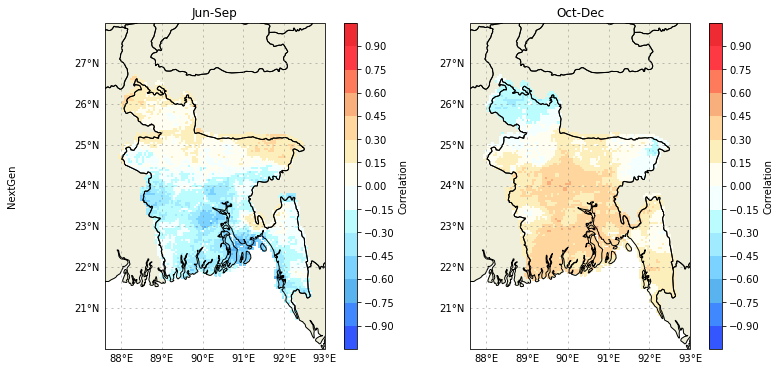


Spearman
failed to add your shape file
failed to add your shape file


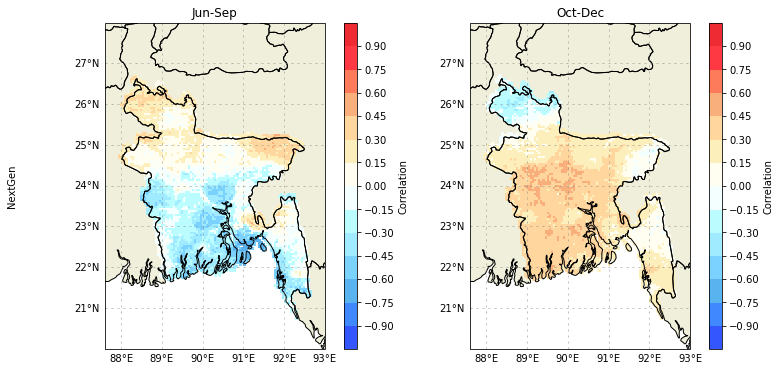


2AFC
failed to add your shape file
failed to add your shape file


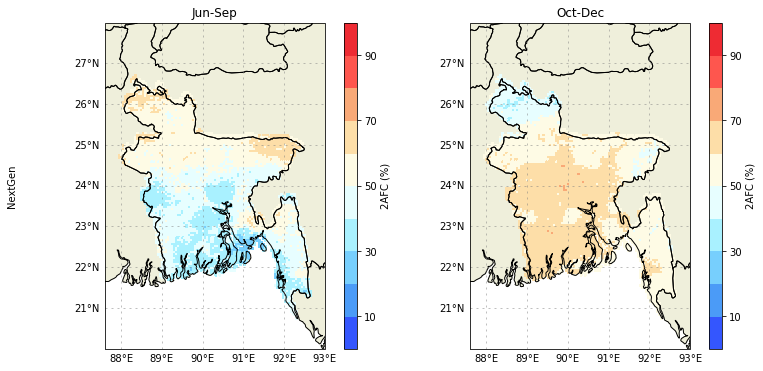


RocAbove
failed to add your shape file
failed to add your shape file


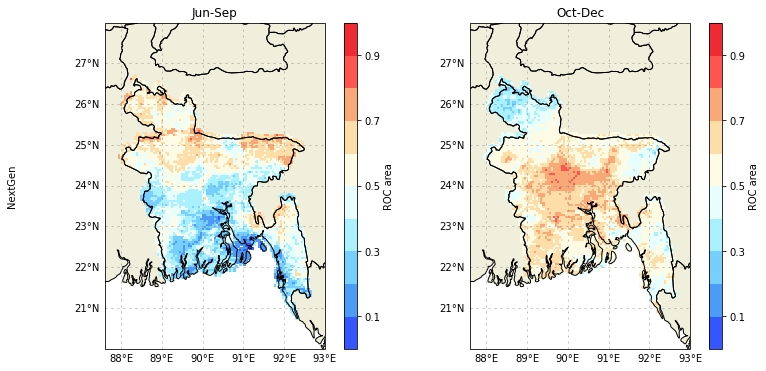


RocBelow
failed to add your shape file
failed to add your shape file


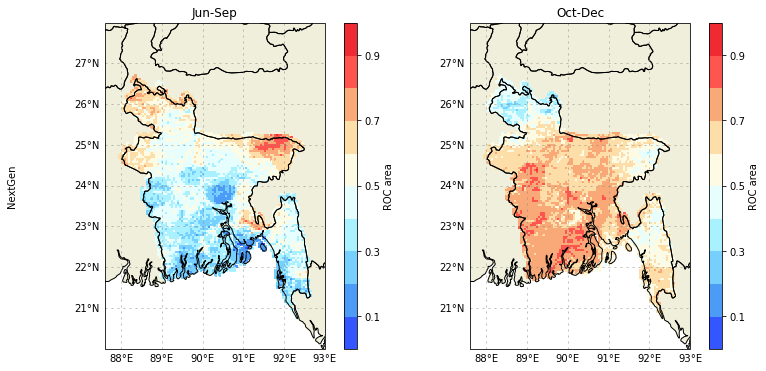


RMSE
failed to add your shape file
failed to add your shape file


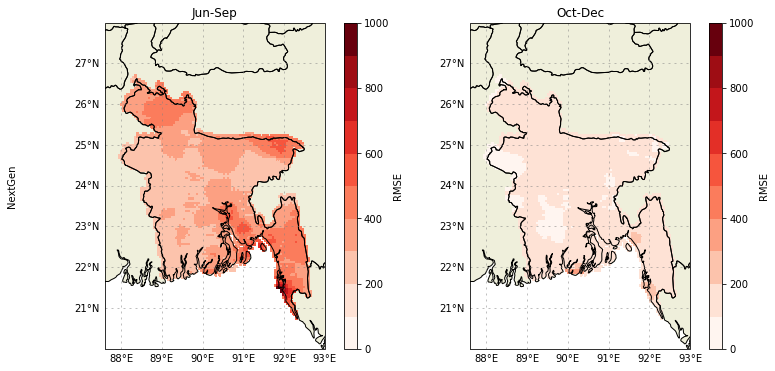

In [8]:
# Skill scores loop
for ime in range(len(met)):
    pycpt.pltmap(ime, isNextGen=1)   

# Real-Time Forecast

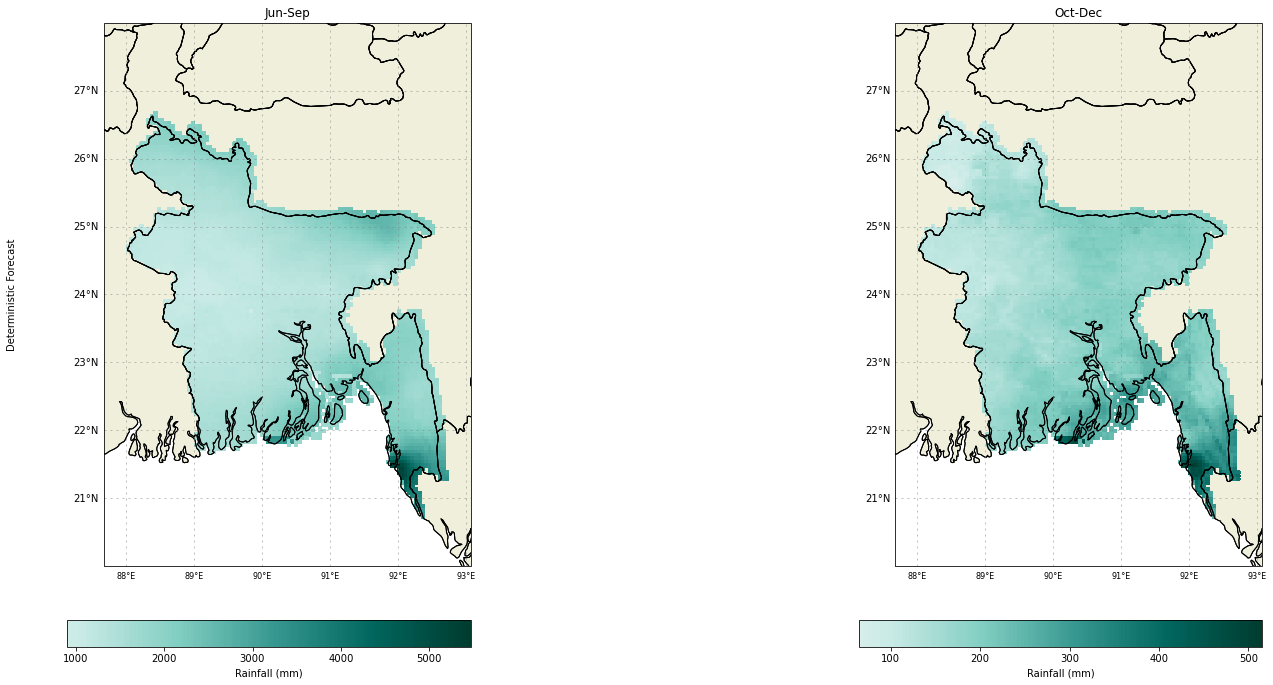

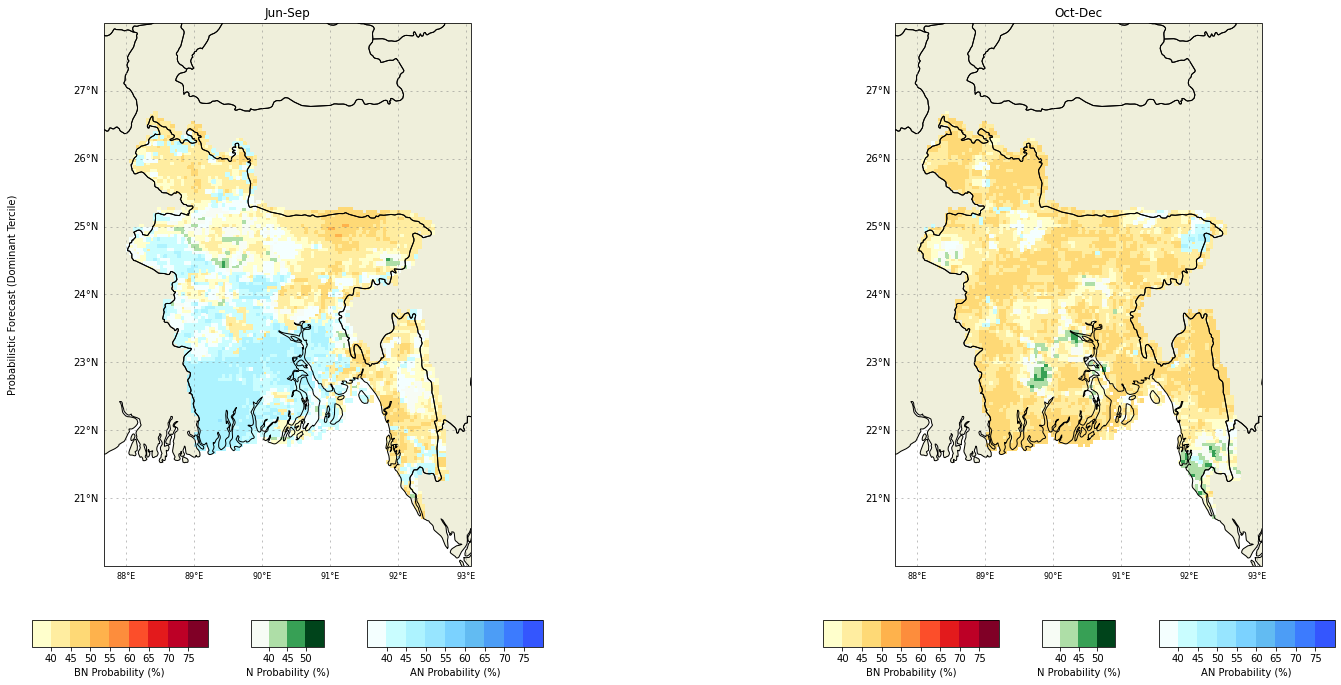

In [9]:
pycpt.plt_ng_deterministic()
pycpt.plt_ng_probabilistic()

In [6]:
models = ['NextGen']
pycpt.setNextGenModels(models)
pycpt.ensemblefiles(['NextGen'],work)

made NextGen
del /s /q ./output/*_NextGen.tgz


Could Not Find C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen\*_NextGen.tgz


del /s /q *.txt


Could Not Find C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen\*.txt


C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_mu_Jun-Sep_May2019.ctl
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_mu_Jun-Sep_May2019.dat
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_mu_Oct-Dec_Sep2019.ctl
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_mu_Oct-Dec_Sep2019.dat
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_P_Jun-Sep_May2019.ctl
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_P_Jun-Sep_May2019.dat
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_P_Oct-Dec_Sep2019.ctl
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_P_Oct-Dec_Sep2019.dat
C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3\output\NextGen_PRCPPRCP_CCAFCST_var_Jun-Sep_May2019.ctl
C:\U

a output/Nextgen/Final_Test3_NextGen.tgz
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_mu_Jun-Sep_May2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_mu_Jun-Sep_May2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_mu_Oct-Dec_Sep2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_mu_Oct-Dec_Sep2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_P_Jun-Sep_May2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_P_Jun-Sep_May2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_P_Oct-Dec_Sep2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_P_Oct-Dec_Sep2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_var_Jun-Sep_May2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_var_Jun-Sep_May2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_var_Oct-Dec_Sep2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_var_Oct-Dec_Sep2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_V_Jun-Sep_May2019.ctl
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_V_Jun-Sep_May2019.dat
a output/Nextgen/NextGen_PRCPPRCP_CCAFCST_V_Oct-Dec

C:\Users\sysadmin\Projects\pctpt2\PyCPT-Dev\Final_Test3
Compressed file Final_Test3_NextGen.tgz created in output/NextGen/
Now send that file to your contact at the IRI
